# *Quantifying Linguistic & Cultural Drift in Twentieth-Century China:* 
## *Diachronic Word Embeddings and Historical Research*

Spencer Stewart

Postdoctoral Fellow, University of Chicago

# Research Context

The late nineteenth and early twentieth centuries witnessed an unprecedented introduction of thousands of loanwords and neologisms into China that radically transformed the Chinese language. Previous scholarship has explored this linguistic shift through the close analysis of individual terms and the compilation of extensive lists of words. The scale and scope of this impact is particularly well suited for text analysis. While this tutorial focuses on Chinese, it aims to illustrate more broadly how computational methods can augment existing scholarship by studying linguistic and cultural changes at different scales.  

# NOTES ON METHODS

*  Close Reading vs Distant Reading

*  Data and Bias

*  80/20 Rule: 

    [Jo Guldi](https://academic.oup.com/ahr/article-abstract/127/2/895/6705108): "...a canny rule of research suggests an 80/20 rule of insight, where promoting research typically leaves 80 percent of the findings of a field undisturbed, contributing at most a 20 percent revision of content. The capacity to highlight new subjects for research as well as new approaches for synthesis is all that is reqiured for a method to be useful for scholars tracking long-term trends and their relationship to short-term change." 


### Working with Chinese data
*  Less scholarship and fewer methods (BUT this is quickly changing)
*  Tokenization: 我喜欢新西兰花
*  Simplified vs Traditional Characters
*  Variant Chinese Characters 异体字 (e.g. 僞 vs 偽, 羣 vs 群)

In [ ]:
#Example of tokenizing traditional vs simplified Chinese - Notice the difference!
import jieba
string_simp = "我喜欢新西兰花"
string_trad = "我喜歡新西蘭花"
print(string_simp + ": " + "/".join(list(jieba.cut(string_simp, cut_all=False))))
print(string_trad + ": " + "/".join(list(jieba.cut(string_trad, cut_all=False))))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.837 seconds.
DEBUG:jieba:Loading model cost 1.837 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


我喜欢新西兰花: 我/喜欢/新西兰/花
我喜歡新西蘭花: 我/喜歡/新/西蘭花


# NOTES ON DATA

The primary corpus for this project is *Eastern Miscellany* 東方雜誌, the flagship periodical published by the Commercial Press from January 1904 to December 1948. 

Commercial Press has been described as "the most important publisher in China during the first half of the twentieth century," with *Eastern Misc* serving as "a key organ of intellectual opinion throughout the forty-some years of its existence" (Hunters, p. 27). *Eastern Misc* covered a wide range of topics including contemporary events, politics, economics, literature, science and technology, and more. 

The *Eastern Misc* Corpus comes from the Shanghai Library. It has been hand-checked to attain an over 99 percent accuracy rate, resulting in a highly reliable and nearly complete record of the publication. 

The loanwords dataset is a list of roughly 1,000 loanwords, neologisms, and transliterations that were transcribed from the appendices of Lydia Liu's *Translingual Practice*. 

# Update and Import Packages

In [ ]:
#Update packages to run in colab
!pip install gensim --upgrade
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=932ccff67d9f1fa6f722a10ca37323c71b323ae246494cccdcc8d0fb66921fe1
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=bdfe2bea486347e13bb20557b448d511650a13d45c207af696ac67641b59054d
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

In [ ]:
#Import packages needed for this tutorial
import sys
import re
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import jieba
from collections import defaultdict
import pickle
import gensim
from gensim.models import Word2Vec
from gensim.models import word2vec
from sklearn.metrics import pairwise
from sklearn.manifold import MDS
from scipy import spatial
from nltk import Text, tokenize
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

In [ ]:
#Loading font to display Chinese characters
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!rm "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

path = '/usr/share/fonts/truetype/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=20)

--2023-02-28 22:03:42--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  26.2MB/s    in 0.4s    

2023-02-28 22:03:43 (26.2 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


# Load Data

## *Eastern Misc* Corpus

In [ ]:
# LOAD Eastern Misc Data as a pandas dataframe
url = "https://drive.google.com/uc?id=198AfDwcU49OUeLPP-Bw_l3XpE3fIqMc_"
output = 'dfzz.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
df = df[df.year < 1950] #Removes a single issue published in 1957
df.head(3)

Downloading...
From: https://drive.google.com/uc?id=198AfDwcU49OUeLPP-Bw_l3XpE3fIqMc_
To: /content/dfzz.csv
100%|██████████| 556M/556M [00:04<00:00, 138MB/s]


,pdflink,journal,year,volume,issue,title,author,page_range,text,text_simp,text_len
0,40862\TXT成品\47353_东方杂志\1944\V040_N0009\txt\003...,东方杂志,1944,40.0,9.0,一個科學家的宗教觀,張宗炳,27-29,一九三四年當我正式的受洗禮時，我曾寫過一篇「我所認識的基督教」，然而當時，除了給少數...,一九三四年当我正式的受洗礼时，我曾写过一篇「我所认识的基督教」，然而当时，除了给少数...,2297
1,40862\TXT成品\47353_东方杂志\1944\V040_N0009\txt\001...,东方杂志,1944,40.0,9.0,戰時省制之演變及其今後之改造,薩師炯,7-12,一\n 抗戰以前，我國省制之基本依據有二：一爲二十年三月二十三日國民政府修正公...,一\n 抗战以前，我国省制之基本依据有二：一为二十年三月二十三日国民政府修正公...,6865
2,40862\TXT成品\47353_东方杂志\1944\V040_N0009\txt\003...,东方杂志,1944,40.0,9.0,春秋硏究綱要,周通旦,30-33,硏究春秋方法，已詳他文（詳如何硏究春秋一文）。茲所明者，爲春秋微言及其全書大意。\n...,研究春秋方法，已详他文（详如何研究春秋一文）。兹所明者，为春秋微言及其全书大意。\n...,4008


In [ ]:
#BASIC METADATA
print(f"Number of articles: {len(df):,}")
print(f"Number of unique author names: {len(df.author.unique()):,}")
print(f"Number of characters: {df.text_len.sum():,}")

Number of articles: 27,066
Number of unique author names: 5,735
Number of characters: 96,661,345


<AxesSubplot:xlabel='year'>

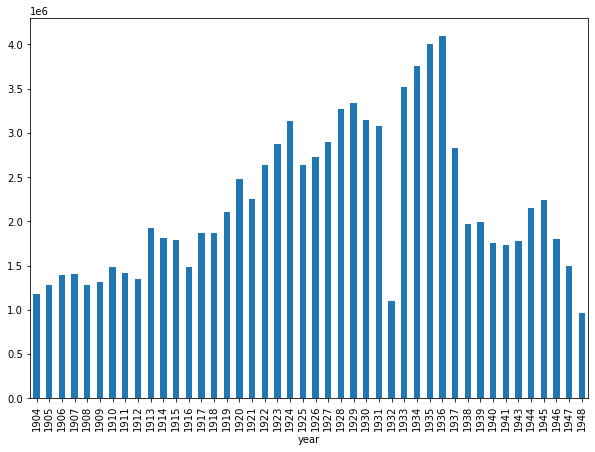

In [ ]:
#QUICK PLOT SHOWING NUMBER OF CHARACTERS PUBLISHED BY YEAR
temp_df = df.groupby(['year']).sum()
temp_df.text_len.plot(kind='bar', figsize=(10, 7))

## Loanwords Dataset

Lydia Liu's compiled lists of foreign loanwords are divided into several different appendices based on type. They include the following: 

* Appendix A: neologisms derived from Missionary-Chinese texts (n=185)
* Appendix B: *Kanji* terms coined by Japanese using Chinese characters to translate European words that were later introduced into China (n=491)
* Appendix C: *Kanji* loan terms that arrived in modern Chinese without necessarily involving European languages (n=51)
* Appendix D: Return graphic loanwords, or classical Chinese-character compounds used by Japanese to translate modern European words and reintroduced into modern Chinese (n=235)
* Appendix F: Transliterations from English, French, and German (n=763)
* Appendix G: Transliterations from Russian (n=78)

In [ ]:
# IMPORT LISTS OF LOANWORDS
url = "https://drive.google.com/uc?id=10FFw4Alg20-cU7YyQlUxC-jRjmNDA1A8"
output = 'tlp.xlsx'
gdown.download(url, output, quiet=False)

#Import each appendix
tlp_a = pd.read_excel('tlp.xlsx', "appendix_a")
tlp_b = pd.read_excel('tlp.xlsx', "appendix_b")
tlp_c = pd.read_excel('tlp.xlsx', "appendix_c")
tlp_d = pd.read_excel('tlp.xlsx', "appendix_d")
tlp_f = pd.read_excel('tlp.xlsx', "appendix_f")
tlp_g = pd.read_excel('tlp.xlsx', "appendix_g")

Downloading...
From: https://drive.google.com/uc?id=10FFw4Alg20-cU7YyQlUxC-jRjmNDA1A8
To: /content/tlp.xlsx
100%|██████████| 232k/232k [00:00<00:00, 61.1MB/s]


In [ ]:
#View Appendix a
tlp_a

,ENGLISH,CHINESE_TRAD,CHINESE_SIMP,CHINESE_ROMANIZATION,NOTES
0,acoustics,聲學,声学,shēngxué,NaN
1,air,空氣,空气,kōngqì,NaN
2,aerostat(1),氣球飛車,气球飞车,qìqiú fēichē,NaN
3,aerostat(2),飛車,飞车,fēichē,NaN
4,airplane,飛機,飞机,fēijī,NaN
...,...,...,...,...,...
180,train ticket,車票,车票,chēpiào,NaN
181,underground,地內火輪車,地内火轮车,denèi huǒ lún chē,NaN
182,university,大學,大学,dàxué,NaN
183,Upper House,上房,上房,shàng fáng,NaN


# SCALING LINGUISTIC CHANGE



The simplest way to understand the scale of linguistic change is to count the frequency with which these new words appeared over time. We will first look at frequencies for the words in all appendices. 


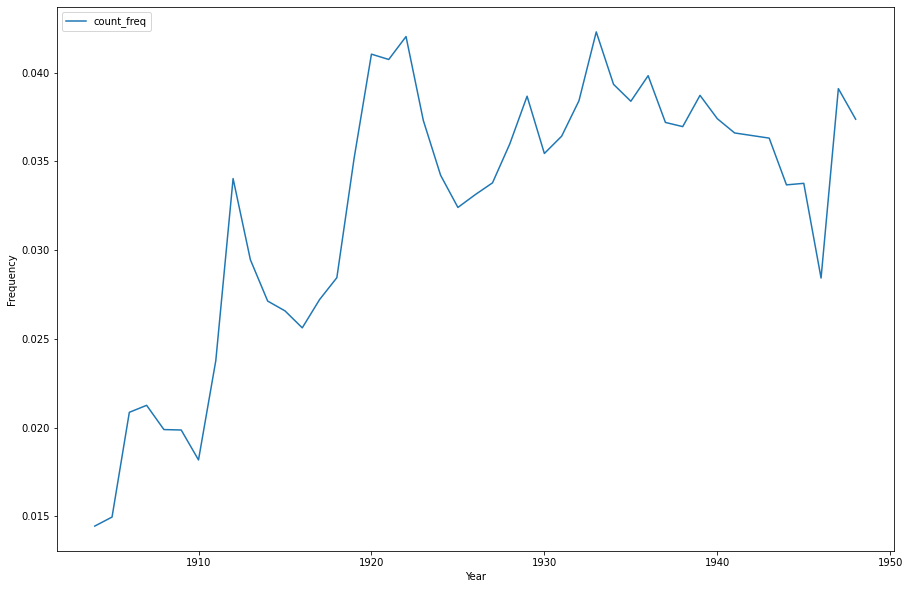

In [ ]:
#WARNING: This will take ~2 min to run

#Create a master list of all words
#Note: I am using simplified characters here to bypass the problem of character variants in traditional Chinese
appendix_list = [tlp.CHINESE_SIMP.tolist() for tlp in [tlp_a, tlp_b, tlp_c, tlp_d, tlp_f, tlp_g]]
word_list = [word for sublist in appendix_list for word in sublist if len(word) > 1] #Remove words that are only one character

#Count how many times each word appear in each text
word_counts = []
for text in df.text_simp.tolist():
    count=0
    for w in word_list:
      count += text.count(w) 
    word_counts.append(count)
    
df['total_counts'] = word_counts
output = df.groupby(['year']).sum()
output['count_freq'] = output.total_counts / output.text_len #Calculate frequency

output["count_freq"].plot(figsize=(15,10)).get_figure()

plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("")
plt.legend(loc=2)
plt.show()

We find that the use of these new foreign loanwords is increasing over time. We can also separate these counts by appendix to see what kinds of words were more frequently used and when. 

In [ ]:
#WARNING: This will take ~2 minutes to run

#WORD FREQUENCIES BY APPENDIX
##We use simplified Chinese to bypass the problem of text variants 异体字 
appendix = [tlp_a, tlp_b, tlp_c, tlp_d, tlp_f, tlp_g]
appendix_name = ["a", "b", "c", "d", "f", "g"]
for a, name in zip(appendix, appendix_name):
    print(f"Counting Appendix {name}, n={len(a)}")
    word_counts = []
    for text in df.text_simp.tolist():
        count=0
        for w in a.CHINESE_SIMP.tolist():
            if len(w) > 1: #Bypass words that are only a single character
                count += text.count(w)   
        word_counts.append(count)
    df['counts_'+name] = word_counts

output = df[df.year < 1950].groupby(['year']).sum()
output['counts_a_freq'] = output.counts_a / output.text_len
output['counts_b_freq'] = output.counts_b / output.text_len
output['counts_c_freq'] = output.counts_c / output.text_len
output['counts_d_freq'] = output.counts_d / output.text_len
output['counts_f_freq'] = output.counts_f / output.text_len
output['counts_g_freq'] = output.counts_g / output.text_len

Counting Appendix a, n=185
Counting Appendix b, n=491
Counting Appendix c, n=51
Counting Appendix d, n=235
Counting Appendix f, n=763
Counting Appendix g, n=78


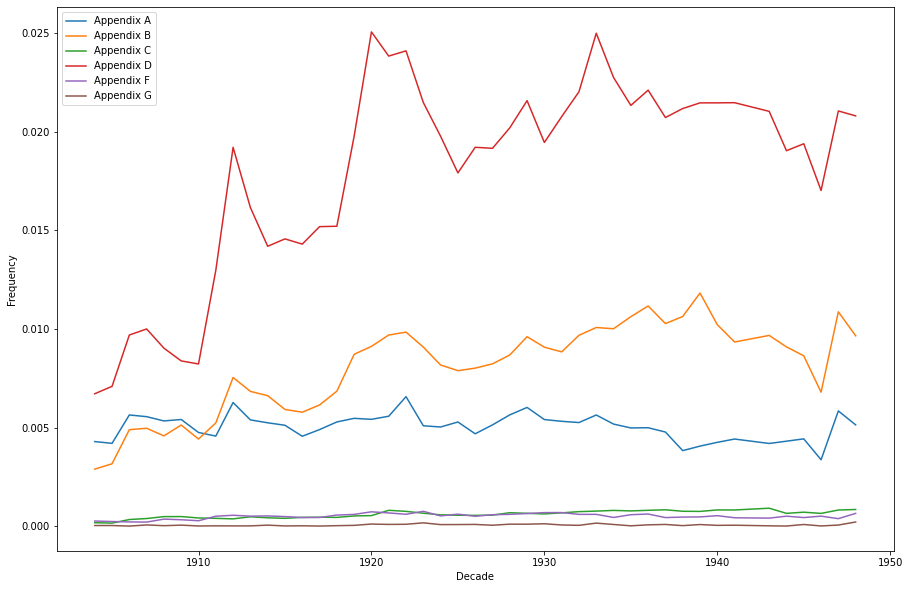

In [ ]:
#VISUALIZE RESULTS

fig = output["counts_a_freq"].plot(figsize=(15,10), label="Appendix A").get_figure()
output["counts_b_freq"].plot(figsize=(15,10), label="Appendix B").get_figure()
output["counts_c_freq"].plot(figsize=(15,10), label="Appendix C").get_figure()
output["counts_d_freq"].plot(figsize=(15,10), label="Appendix D").get_figure()
output["counts_f_freq"].plot(figsize=(15,10), label="Appendix F").get_figure()
output["counts_g_freq"].plot(figsize=(15,10), label="Appendix G").get_figure()

plt.xlabel("Decade")
plt.ylabel("Frequency")
plt.title("")
plt.legend(loc=2)
plt.show()

The results show that the most frequently appearing words come from Appendix D (return graphic loanwords), Appendix B (Kanji terms coined by Japanese using Chinese characters), and Appendix A (neologisms derived from Missionary-Chinese texts). It turns out that despite having the highest total number of individual words, Appendix F (Transliterations from English, French, and German) ranked relatively low on the list compared to the other appendices. 

Q: What do these findings tell us about the nature of linguistic change in China during this time -- and what types of words were more likely to be adopted? 

Q: What are some strengths and limitations of word counts?

# WORD EMBEDDINGS - Tracing linguistic and cultural drift

## Introduction

Word embeddings can provide more detail regarding the context and meaning of these words, along with how they evolved over time. 

Introduction to Word Embeddings: 

* "You shall know a word by the company it keeps" (Firth)

* Word embeddings look for words that share higher-order relationships to one another (countries, animals, automobile companies, etc). It does this by looking for words that have similar co-occurring terms.

* Word embeddings place all of the words in our corpus into a large multidimensional space where the proximity between words represents their degree of similarity.

* Predictive model - each time you run it the results will be a little different

* Word embeddings are mathematically complex, making them a "black box" for most of us. But as Ryan Heuser points out, it is still a "useful black box" as word embeddings have been shown to "provide a spatial representation of word similarity that is statistically robust and has been demonstrated to provide state-of-the-art accuracy in a wide range of NLP tasks." ([Heuser](https://ryanheuser.org/word-vectors-2/))

* Useful for understanding both the linguistic and cultural meanings of words, including how these words have changed over time (see [Hamilton](https://cs.stanford.edu/people/jure/pubs/diachronic-acl16.pdf))

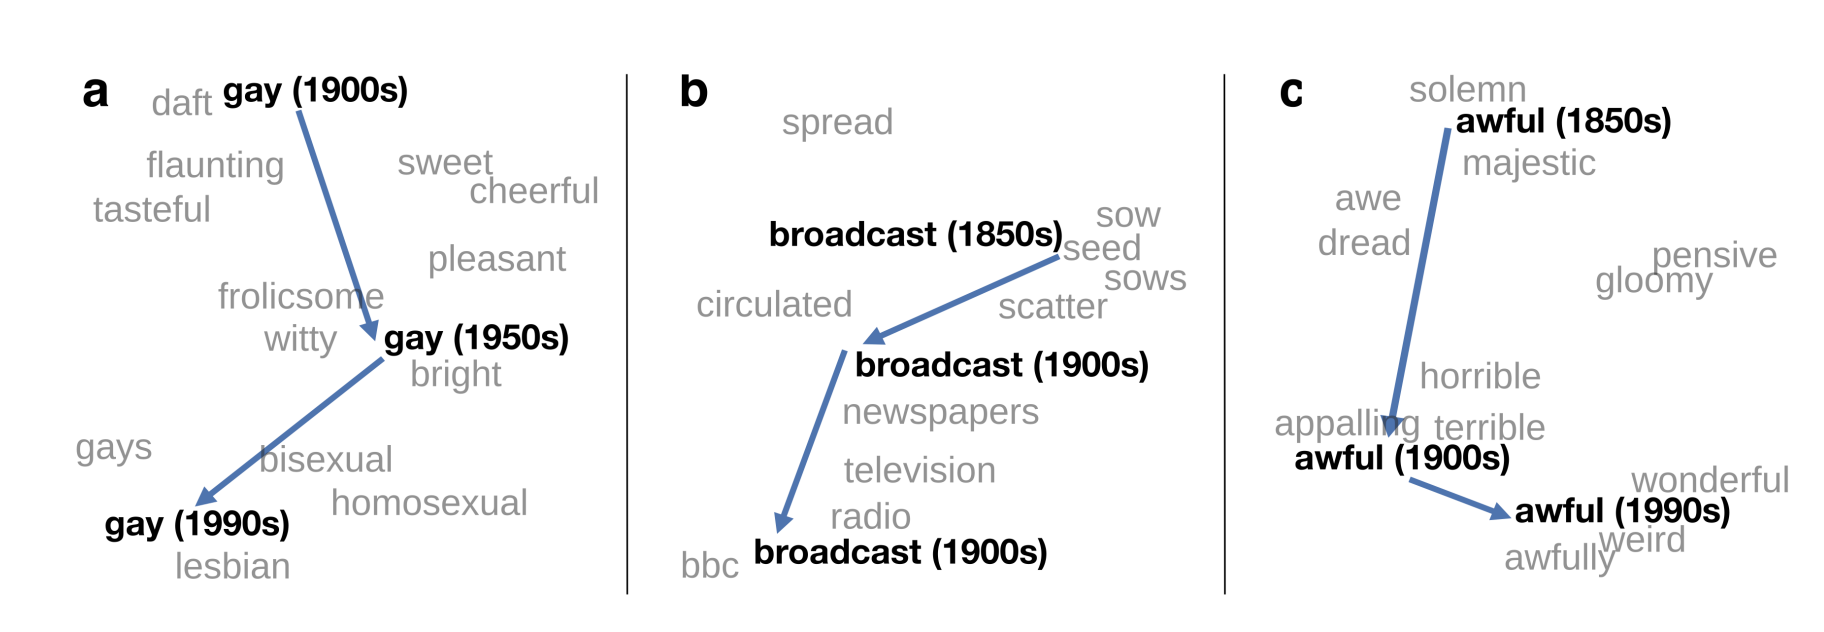

Liu: "Instead of continuing to do so-called influence studies in the time-honored sense of comparative literature, one could stress the agency of the host language (modern Chinese in this case) in the meaning-making process of translation so that the guest language need not carry a signature of authenticity around in order to make sense in the new context." (p. 29)

Can we use word embeddings to quantify this meaning-making process?

Note: Word embeddings seem to capture linguistic shifts better when using longer datasets. This isn't to say linguistic drift can't be measured over a 40-50 year timeframe. Rather, what we seem more likely to find are shifts in cultural meaning.

## Generating Diachronic Word Embeddings

Rather than creating a single word embedding model on the entire corpus, here we will instead split the corpus by decade and generate a model based on each sub-dataset. 
* model1: 1904-1909  
* model2: 1910-1919 
* model3: 1920-1929  
* model4: 1930-1939  
* model5: 1940-1949

The following functions were used to create multiple word embedding models and align them so that we can accurately quantify change over time. The code here is provided for your future reference. Because it takes a long time to run, we will instead move onto the next section where we will simply load the pre-trained models. 

In [ ]:
#Function that will tokenize Chinese text by sentence based on custom year range
def word_2_vec_sent(df, variable, year_start, year_end):
    
    #LOAD CHINESE STOPWORD LIST
    url = "https://drive.google.com/uc?id=1vSZZVNjJOBSloRtBctinAItJBvNjrRBo"
    output = 'stopwords.txt'
    gdown.download(url, output, quiet=False)
    with open("stopwords.txt") as stopwords:
        zh_stopwords = set(stopwords.read().rsplit('\n'))
    print("Stopwords Loaded")

    #DIVIDE CORPUS BY SPECIFIED YEARS    
    temp_df = df[(df['text'].notna()) & (df['year'] >= year_start) & (df['year'] < year_end)].reset_index()
    full_text = ' '.join([str(elem) for elem in temp_df[variable].tolist()])
    
    print("Tokenizing by sentence")
    
    sentences = []
    full_text = full_text.replace("\n", "")
    full_text = full_text.replace(" ", "")
    split_text = re.split(r'[。！？]', full_text) #CUSTOM TOKENIZER BY SENTENCE
    
    #Tokenize each sentence -- using Jieba
    for sentence in split_text:
        #tokens = jieba.cut(sentence, cut_all=True) #Full Mode - multiple possible tokens
        tokens = jieba.cut(sentence, cut_all=False) #Only one possible token
        sentences.append([s for s in tokens if s not in zh_stopwords])
    
    return sentences

In [ ]:
#Function to generate word2vec model
def word_2_vec_model(sentences, window_size=2):
    print("Creating word2vec model")
    model = word2vec.Word2Vec(
        sentences,
        vector_size=100,
        window=window_size,
        seed=42,
        workers=1,
        sg=0,
        alpha=0.025, 
        batch_words=10000,
        min_count=10)
    
    return model

In [ ]:
# FUNCTIONS to align a list of models
# CODE adapted from: https://gist.github.com/tangert/106822a0f56f8308db3f1d77be2c7942
# Code originally ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
from functools import reduce
import numpy as np

def intersection_align_gensim(models, words=None):
    """
    Returns the aligned/intersected models from a list of gensim word2vec models.
    Generalized from original two-way intersection as seen above.
    
    Also updated to work with the most recent version of gensim
    Requires reduce from functools
    
    In order to run this, make sure you run 'model.init_sims()' for each model before you input them for alignment.
    
    ##############################################
    ORIGINAL DESCRIPTION
    ##############################################
    
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocabs = [set(m.wv.index_to_key) for m in models]

    # Find the common vocabulary
    common_vocab = reduce((lambda vocab1,vocab2: vocab1&vocab2), vocabs)
    if words: common_vocab&=set(words)
        
    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: sum([m.wv.get_vecattr(w, "count") for m in models]),reverse=True)
    print(common_vocab[:10])
    print(len(common_vocab))
    # Then for each model...
    for m in models:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return models

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # re-filling the normed vectors
    #patch by amaconovic: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
    base_embed.wv.fill_norms(force=True)
    other_embed.wv.fill_norms(force=True)

    # get the (normalized) embedding matrices
    base_vecs = base_embed.wv.get_normed_vectors()
    other_vecs = other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

In [ ]:
# #CREATE WORD2VEC MODELS - WARNING THIS WILL TAKE A LONG TIME
# #Instead of running this code, you can load the pre-trained models below

# years = [1904,1910,1920,1930,1940,1950]

# #Generate word2vec models for each time period
# models = []
# for y in range(len(years)-1):
#     sentences = word_2_vec_sent(df, variable="text_simp", year_start=years[y], year_end=years[y+1])
#     m = word_2_vec_model(sentences)
#     models.append(m)

# #Intersection alignment
# intersection_align_gensim(models)

# #smart_procrustes_align_gensim
# align_models = []
# align_models.append(models[0])
# for m in models[1:]:
#     a_m = smart_procrustes_align_gensim(models[0], m)
#     align_models.append(a_m)

## Loading and Analyzing Word Embeddings

### Load pre-trained models

In [ ]:
#Load the pre-trained model

url = "https://drive.google.com/uc?id=1e5_0_WM8VrqDOm3ym-KdgYUlx65-uA3_"
output = "aligned_model"
gdown.download(url, output, quiet=False)

with open('aligned_model', 'rb') as f:
    models = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1e5_0_WM8VrqDOm3ym-KdgYUlx65-uA3_
To: /content/aligned_model
100%|██████████| 146M/146M [00:01<00:00, 144MB/s]


### Calculate "drift" for words in Appendix D

In [ ]:
#Function to measure cosine similarity across two models
#copy of the word2vec "similarity" function, but adjusted to pass two different models.
#code: https://github.com/RaRe-Technologies/gensim/blob/247da47c8d45605416900b31eb082be5ceb87331/gensim/models/keyedvectors.py
def cosine_similarity(word,modelx, modely):
    return np.dot(gensim.matutils.unitvec(modelx.wv[word]), gensim.matutils.unitvec(modely.wv[word]))

In [ ]:
#MEASURE "DRIFT" FROM MODEL1 TO MODEL5

app_d_wordlist = tlp_d.CHINESE_SIMP.tolist() #create list of words from appendix d

words = list(set([w for w in app_d_wordlist if w in models[0].wv.key_to_index])) #Remove words not present in model

drift = []
for word in words:
    drift.append(1-cosine_similarity(word,models[0],models[4])) #Note: 1-similarity = "drift"

drift_df = pd.DataFrame({
    "word": words,
    "drift": drift
    })

In [ ]:
#Display words that drift more than 0.5
drift_df[drift_df.drift > 0.5] 

,word,drift
43,作战,0.595062
58,单位,0.551158
59,检讨,0.892968
81,方面,0.612538
84,事变,0.560292
111,机会,0.530926
144,游击,0.608213
165,相对,0.525768
180,注射,0.524617


### CASE 1: *jiantao* 检讨 and Linguistic Drift

Based on the results above, we find that the word that "drifts" the most is *jiantao* 检讨. *Jiantao* is a "return graphic loanword" that was originally a title associated with the Hanlin accademy but came to mean 'reflection' or 'self-criticism'. To trace this transformation, we can display the top words associated with *jiantao*. The results below confirm this transformation. 

In [ ]:
#TOP WORDS BY DECADE
word = '检讨'

word_df = pd.DataFrame(
    {
        "1904-1909": [w for w,c in models[0].wv.most_similar(word, topn=10)],
        "1910-1919": [w for w,c in models[1].wv.most_similar(word, topn=10)],
        "1920-1929": [w for w,c in models[2].wv.most_similar(word, topn=10)],
        "1930-1939": [w for w,c in models[3].wv.most_similar(word, topn=10)],
        "1940-1949": [w for w,c in models[4].wv.most_similar(word, topn=10)]
    }
)
word_df

,1904-1909,1910-1919,1920-1929,1930-1939,1940-1949
0,编修,楹,管见,探讨,作一
1,翰林,曾孙,参以,作一,讨论
2,三品,姜,未暇,审察,详尽
3,太常,诒,愚见,阐明,略加
4,翰林院,太常,管见所及,说明,详加
5,典籍,崧,西学,详述,商榷
6,殿,仁寿,明其,商榷,尚待
7,四品,金色,涉猎,申说,报告
8,国子监,南城,揣摩,简略,初步
9,并加,庠,当否,分析,探讨


We can also visualize this change below:  

*Note the problems with dimention reduction*

In [ ]:
k = 10
tokens = list(set([w for m in models for w,c in m.wv.most_similar(word, topn=k) if len(w) > 1]))

vectors = [models[0].wv[word]] + [models[2].wv[word]] + [models[4].wv[word]]
vectors += [models[4].wv[word] for word in tokens] 

dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')

mds = MDS(n_components = 2, dissimilarity='precomputed')

embeddings = mds.fit_transform(dist_matrix)

labels = [word+'_1900s', word+'_1920s',word+'_1940s'] + tokens

m1_embeddings_df = pd.DataFrame({
    "label":labels,
    "x": embeddings[:,0],
    "y": embeddings[:,1]
})

<ipython-input-23-7fc6c760a170>:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid (b=False)


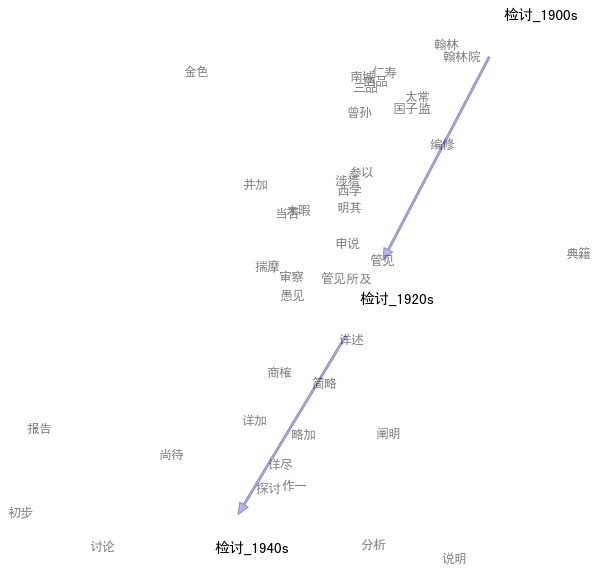

In [ ]:
# Code below was adjusted from the following paper: https://culturalanalytics.org/article/18841-abolitionist-networks-modeling-language-change-in-nineteenth-century-activist-newspapers
# Adjusted to display Chinese characters and a varying number of target_word_annotations

target_word_annotations = 3

df_2dims = m1_embeddings_df

# The data to plot is in df_2dims which is a pandas dataframe 
# The dataframe should have two columns "x" and "y" corresponding to the x and y coordinates. 
# The word should be in another column named "label"

offset = 1e-4

fig, ax = plt.subplots(figsize=(10,10))

# don't show grid
ax.grid (b=False)

# hide the axes
ax.set_frame_on (False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# set the x and y limit
ax.set_xlim (left=min(df_2dims.x) - offset, right=max (df_2dims.x) + offset)
ax.set_ylim (bottom=min(df_2dims.y) - offset, top=max(df_2dims.y) + offset)

# scatter plot (make the markers transparent)
#ax.scatter(df_2dims.x, df_2dims.y, s=3, alpha=0.9) # not really required

# First, just show the target word
for x, y, label in zip (df_2dims.x.values[0:target_word_annotations], 
                        df_2dims.y.values[0:target_word_annotations], 
                        df_2dims.label.values[0:target_word_annotations]):
  #ax.annotate (label, xy=(x,y), fontsize=14, fontweight='bold')
  ax.text (x,y,label,color='black',size=15, fontweight='bold', zorder=10, fontproperties=fontprop)

for x,y, label in zip (df_2dims.x.values[target_word_annotations:],
                       df_2dims.y.values[target_word_annotations:],
                       df_2dims.label.values[target_word_annotations:]):
  # special cases hardcode
  if not label == 'congress' and not label=='thrusting' and not label=='dining-room' and not label == 'electing':
    ax.text (x,y,label,color='grey',size=13, zorder=5, fontproperties=fontprop)

# Now show the arrows
target_word_annotations = [(x,y,label) for x, y, label in zip (df_2dims.x.values[0:target_word_annotations], 
                                                               df_2dims.y.values[0:target_word_annotations], 
                                                               df_2dims.label.values[0:target_word_annotations])]

for j, k in zip (range (len(target_word_annotations) - 1), range (1, len (target_word_annotations))):
    off=0.01
    ax.annotate ('', xy=(target_word_annotations[k][0], target_word_annotations[k][1]), 
             xytext=(target_word_annotations[j][0]+off, target_word_annotations[j][1]+off), 
             arrowprops=dict(facecolor='blue', shrink=0.15, alpha=0.3,width=2, headwidth=10),
             zorder=10)

Visualizations such as this are misleading as it compresses n-dimensions down to just two. But such visualizations can still be useful in demonstrating the types of linguistic drift that were taking place in China during the first half of the twentieth century. The results of both the table and graph show how the term *jiantao* retained its meaning from classical Chinese during the first decade of the twentieth century, but by the 1940s had taken on new linguistic meaning with its close association to terms such as "discuss", "analysis", "describe", etc. 

### CASE 2: *geming* 革命 and Cultural Drift; a conceptual history of revolution?

Word embeddings not only highlight linguistic shifts, but can also reveal important cultural transformations. The term *geming* or 'revolution' didn't experience significant linguistic shifts during the first half of the twentieth century, but word embeddings still reveal important cultural changes. 

What changes do you notice taking place in the data below?

In [ ]:
#TOP WORDS BY DECADE
word = '革命'

word_df = pd.DataFrame(
    {
        "1904-1909": [w for w,c in models[0].wv.most_similar(word, topn=10)],
        "1910-1919": [w for w,c in models[1].wv.most_similar(word, topn=10)],
        "1920-1929": [w for w,c in models[2].wv.most_similar(word, topn=10)],
        "1930-1939": [w for w,c in models[3].wv.most_similar(word, topn=10)],
        "1940-1949": [w for w,c in models[4].wv.most_similar(word, topn=10)]
    }
)
word_df

,1904-1909,1910-1919,1920-1929,1930-1939,1940-1949
0,共和,政变,专政,民族主义,专政
1,进于,内乱,政变,叛乱,鼓吹
2,希望,失败,革命党,共和,兴起
3,民权,变乱,反动,革命者,暴动
4,一变,建国,暴动,煽动,运动
5,中央集权,革命党,叛乱,国民党,二十世纪
6,而知,叛乱,维新,反动,十八世纪
7,学说,无政府,煽动,政变,社会主义
8,文化,日俄战争,革命者,社会主义,民族主义
9,政治家,勃发,复兴,专政,号召


The results above highlight important political and socio-cultural shifts taking place in China during this fifty-year period. We find that in the final years of the Qing dynasty (which collapsed in 1911), the term revolution was associated with terms such as Republicanism, hope, civil rights, and change. With the fall of the Qing and the rocky political foundations of the Republic of China in the 1910s, revolution came to be associated with coups, civil strife, failure, chaos, and even anarchy. Some of these associations continued into the 1940s, but the general trend beginning in the 1930s appears to be a growing concern over competing political factions that were challenging the then Nationalist party at that time. In particular, terms pop up associated with the Chinese Communist Party such as reactionaries, dictatorships, and even socialism. A conceptual history of revolution in China as seen through these word vectors would therefore highlight the hopes for political change in the first decade of the twentieth century, the frustrations with the outcomes of said revolution in the 1910s, and the conflicting realities of the 1920s to 1940s with the rise of competing political parties and a rethinking of cultural assumptions regarding the utility and value of revolution. 

# CONCLUSIONS

## Scaling *Translingual Practice*

* Word embeddings can provide new insights into the scale and scope of linguistic change in China during the first half of the twentieth century.
* It can provide new tools for data exploration.
* It can also allow us to scale up close readings to understand the representativeness of individual case studies. 

## Implications for historical research

* Scaling Up vs. Data Exploration

* Close Reading vs. Distant Reading

* "History's Perpetual Future Tense" ([Blevins](https://dhdebates.gc.cuny.edu/read/untitled/section/4555da10-0561-42c1-9e34-112f0695f523))

* The value of convergence